In [1]:
import numpy as np
import sympy as sp
import scipy as sсp
import matplotlib.pyplot as plt
import math
from matplotlib import cm
from time import time
from random import shuffle
from math import exp

# регрессии

## методы из этой лабы


### loss_function

In [48]:
def loss_function(Y, X, theta, func):
    sum = 0
    for i in range(len(Y)):
      sum += (Y[i] - func(theta, X[i]))**2
    return sum

### Gauss-Newton

In [264]:
def gauss_newton(X, Y, coefficients, loss_function, func, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        loss = np.array([0 for i in range(len(Y))], dtype=np.float64)
        for i in range(len(loss)):
          loss[i] = func(theta, X[i]) - Y[i]
        jacobian = []
        for i, parameter in enumerate(theta):
            x = theta.copy()
            x[i] += eps
            new_loss = np.array([0 for i in range(len(Y))], dtype=np.float64)
            for i in range(len(loss)):
              new_loss[i] = func(x, X[i]) - Y[i]
            derivative = (new_loss - loss) / eps
            jacobian.append(derivative)
        jacobian = np.array(jacobian, dtype=np.float64).T
        theta = theta - np.linalg.pinv(jacobian.T @ jacobian) @ jacobian.T @ loss
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     newton")
    return theta

### Powell-dog-leg

In [160]:
def dogleg_method(hessian_inv, grad, hessian, trust_radius):
          pB = -np.dot(hessian_inv, grad)
          norm_pB = np.sqrt(pB.T @ pB)

          if norm_pB <= trust_radius:
              return pB
          
          pU = - ((grad.T @ grad) / np.dot(grad, np.dot(hessian, grad))) * grad
          dot_pU = pU.T @ pU
          norm_pU = np.sqrt(dot_pU)

          if norm_pU >= trust_radius:
              return trust_radius * pU / norm_pU

          pB_pU = pB - pU
          dot_pB_pU = np.dot(pB_pU, pB_pU)
          dot_pU_pB_pU = np.dot(pU, pB_pU)
          fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - trust_radius**2)
          tau = (-dot_pU_pB_pU + np.sqrt(fact)) / dot_pB_pU
          
          return pU + tau * pB_pU

def powell_dog_leg(X, Y, coefficients, loss_function, func, loss_function_grad, hessian_func, eps=1e-4, initial_trust_radius=1.0, max_trust_radius=100.0, eta=0.15, gtol=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    trust_radius = initial_trust_radius
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        grad = np.array([0 for i in range(len(theta))], dtype=np.float64)
        hessian = np.array([[0 for i in range(len(theta))] for _ in range(len(theta))], dtype=np.float64)
        for i in range(len(theta)):
            for k in range(len(Y)):
              grad[i] += loss_function_grad[i](theta, Y[k], X[k])
        for i in range(len(theta)):
          for j in range(len(theta)):
            for k in range(len(Y)):
              hessian[i][j] += hessian_func[i][j](theta, Y[k], X[k])
        hessian_inv = np.linalg.pinv(hessian)

        pk = dogleg_method(hessian_inv, grad, hessian, trust_radius)
        act_red = loss_function(Y, X, theta, func) - loss_function(Y, X, theta + pk, func)
        pred_red = -(np.dot(grad, pk) + 0.5 * np.dot(pk, np.dot(hessian, pk)))

        rhok = act_red / pred_red
            
        norm_pk = np.sqrt(np.dot(pk, pk))

        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
        else:
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2 * trust_radius, max_trust_radius)
        
        if rhok > eta:
            theta = theta + pk

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     dogleg")
    return theta

### BFGS

In [55]:
def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0] * len(theta)
    for j in range(len(theta)):
        summ = 0
        for i in range(len(Y)):
            summ += loss_function_grad[j](theta, Y[i], X[i])
        grad[j] = summ
    return grad

def first_condition(x, loss_function, loss_function_grad, alpha, c1=1e-4):
  grad = np.array(loss_function_grad(x))
  x1 = x - alpha * grad
  if loss_function(x1) <= loss_function(x) + alpha * c1 * np.dot(grad, -grad):
    return True
  else:
    return False

def backtracking_line_search(x, loss_function, loss_function_grad, c1=1e-4, c2=0.9, min_value=1):
    alpha = 20
    while (not first_condition(x, loss_function, loss_function_grad, alpha)):
      alpha = alpha * 0.95
      if alpha < min_value:
        break
    return alpha

def bfgs(X, Y, coefficients, loss_function, func, loss_function_grad, symbols, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    gfk = np.array(grad_for_scp(Y, X, theta, loss_function_grad))
    N = len(theta)
    I = np.eye(N, dtype=int)
    Hk = I
    epoch = 1
    f = sp.lambdify([symbols], loss_function(Y, X, symbols, func), 'numpy')
    f1 = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        pk = -np.dot(Hk, gfk)
        alpha_k = backtracking_line_search(theta, f, f1)
        xkp1 = theta + alpha_k * pk
        sk = xkp1 - theta
        theta = xkp1

        gfkp1 = np.array(grad_for_scp(Y, X, xkp1, loss_function_grad))
        yk = gfkp1 - gfk
        gfk = gfkp1

        ro = 1.0 / (np.dot(yk, sk))
        A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
        A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
        Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     bfgs")
    return theta

### L-BFGS

In [207]:
def grad_for_scp(Y, X, theta, loss_function_grad):
    grad = [0] * len(theta)
    for j in range(len(theta)):
        summ = 0
        for i in range(len(Y)):
            summ += loss_function_grad[j](theta, Y[i], X[i])
        grad[j] = summ
    return grad

def first_condition(x, loss_function, loss_function_grad, alpha, c1=1e-4):
  grad = np.array(loss_function_grad(x))
  x1 = x - alpha * grad
  if loss_function(x1) <= loss_function(x) + alpha * c1 * np.dot(grad, -grad):
    return True
  else:
    return False

def backtracking_line_search(x, loss_function, loss_function_grad, c1=1e-4, c2=0.9, min_value=1):
    alpha = 20
    while (not first_condition(x, loss_function, loss_function_grad, alpha)):
      alpha = alpha * 0.95
      if alpha < min_value:
        break
    return alpha

def lbfgs_update(sk_list, yk_list, rho_list, q):
    a = [0] * len(sk_list)

    for i in reversed(range(len(sk_list))):
        rho = rho_list[i]
        alpha = rho * np.dot(sk_list[i], q)
        q = q - alpha * yk_list[i]
        a[i] = alpha

    gamma = np.dot(sk_list[-1], yk_list[-1]) / np.dot(yk_list[-1], yk_list[-1])
    r = gamma * q

    for i in range(len(sk_list)):
        rho = rho_list[i]
        beta = rho * np.dot(yk_list[i], r)
        r = r + sk_list[i] * (a[i] - beta)

    return r

def lbfgs(X, Y, coefficients, loss_function, func, loss_function_grad, symbols, eps=1e-4, m=10):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    gfk = np.array(grad_for_scp(Y, X, theta, loss_function_grad))
    epoch = 1
    f = sp.lambdify([symbols], loss_function(Y, X, symbols, func), 'numpy')
    f1 = sp.lambdify([symbols], grad_for_scp(Y, X, symbols, loss_function_grad), 'numpy')
    sk_list = []
    yk_list = []
    rho_list = []
    pk = 0
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        if epoch == 1:
          pk = -gfk
        else:
          pk = -lbfgs_update(sk_list, yk_list, rho_list, gfk)
        alpha_k = backtracking_line_search(theta, f, f1)

        xkp1 = theta + alpha_k * pk
        sk = xkp1 - theta
        theta = xkp1

        gfkp1 = np.array(grad_for_scp(Y, X, xkp1, loss_function_grad))
        yk = gfkp1 - gfk
        gfk = gfkp1

        rho = 1.0 / (np.dot(yk, sk))
        if len(sk_list) == m:
            sk_list.pop(0)
            yk_list.pop(0)
            rho_list.pop(0)
        sk_list.append(sk)
        yk_list.append(yk)
        rho_list.append(rho)

        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
        
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     l-bfgs")
    return theta

## методы из прошлых лаб

### just GD

In [152]:
def gd(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        theta = theta - lr * derivatives
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     gd")
    return theta

### momentum

In [161]:
def gd_with_momentum(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, alpha=0.9, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        g = alpha * g + (1 - alpha) * lr * derivatives
        theta = theta - g
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     momentum")
    return theta

### nesterov

In [150]:
def gd_with_nesterov(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, alpha=0.9, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        theta -= alpha * g
        g = alpha * g + (1 - alpha) * lr * derivatives
        theta = theta - g
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     nesterov")
    return theta

### adagrad

In [149]:
def gd_with_adagrad(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ -= loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        g += derivatives ** 2
        theta = theta + lr / (g ** 0.5) * derivatives
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     adagrad")
    return theta

### rmsprop

In [148]:
def gd_with_rmsprop(X, Y, coefficients, loss_function, func, loss_function_grad, lr=2, eps=1e-4, gamma=0.9, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    g = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ -= loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        g = gamma * g + (1 - gamma) * derivatives ** 2
        theta = theta + lr / (g ** 0.5 + 1e-6) * derivatives
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     rmsprop")
    return theta

### adam

In [147]:
def gd_with_adam(X, Y, coefficients, loss_function, func, loss_function_grad, lr=0.1, eps=1e-4, b1=0.9, b2=0.999, max_iter=500):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(Y, X, theta, func)
    m = np.zeros(len(theta), dtype=np.float64)
    v = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps and epoch < max_iter:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ -= loss_function_grad[j](theta, Y[i], X[i])
            derivatives[j] = summ
        m = b1 * m + (1 - b1) * derivatives
        v = b2 * v + (1 - b2) * derivatives ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta + lr / (vv ** 0.5 + eps) * mm
        current_cost = loss_function(Y, X, theta, func)
        epoch += 1
    print(f"current_cost: {current_cost}, epoch: {epoch-1}     adam")
    return theta

## testing

### 1 функция

initial: [1, 1, 1, 1]
current_cost: 130.341104246775, epoch: 499     gd
current_cost: 119.118988608044, epoch: 499     momentum
current_cost: 109.778164681375, epoch: 499     nesterov
current_cost: 37.9165789409952, epoch: 499     adagrad
current_cost: 43.8856911644511, epoch: 499     rmsprop
current_cost: 34.9293901068831, epoch: 232     adam
current_cost: 34.9293734533875, epoch: 2     newton
current_cost: 34.9293734533875, epoch: 3     dogleg
current_cost: 34.9293734534517, epoch: 15     bfgs
current_cost: 34.9293734538674, epoch: 32     l-bfgs


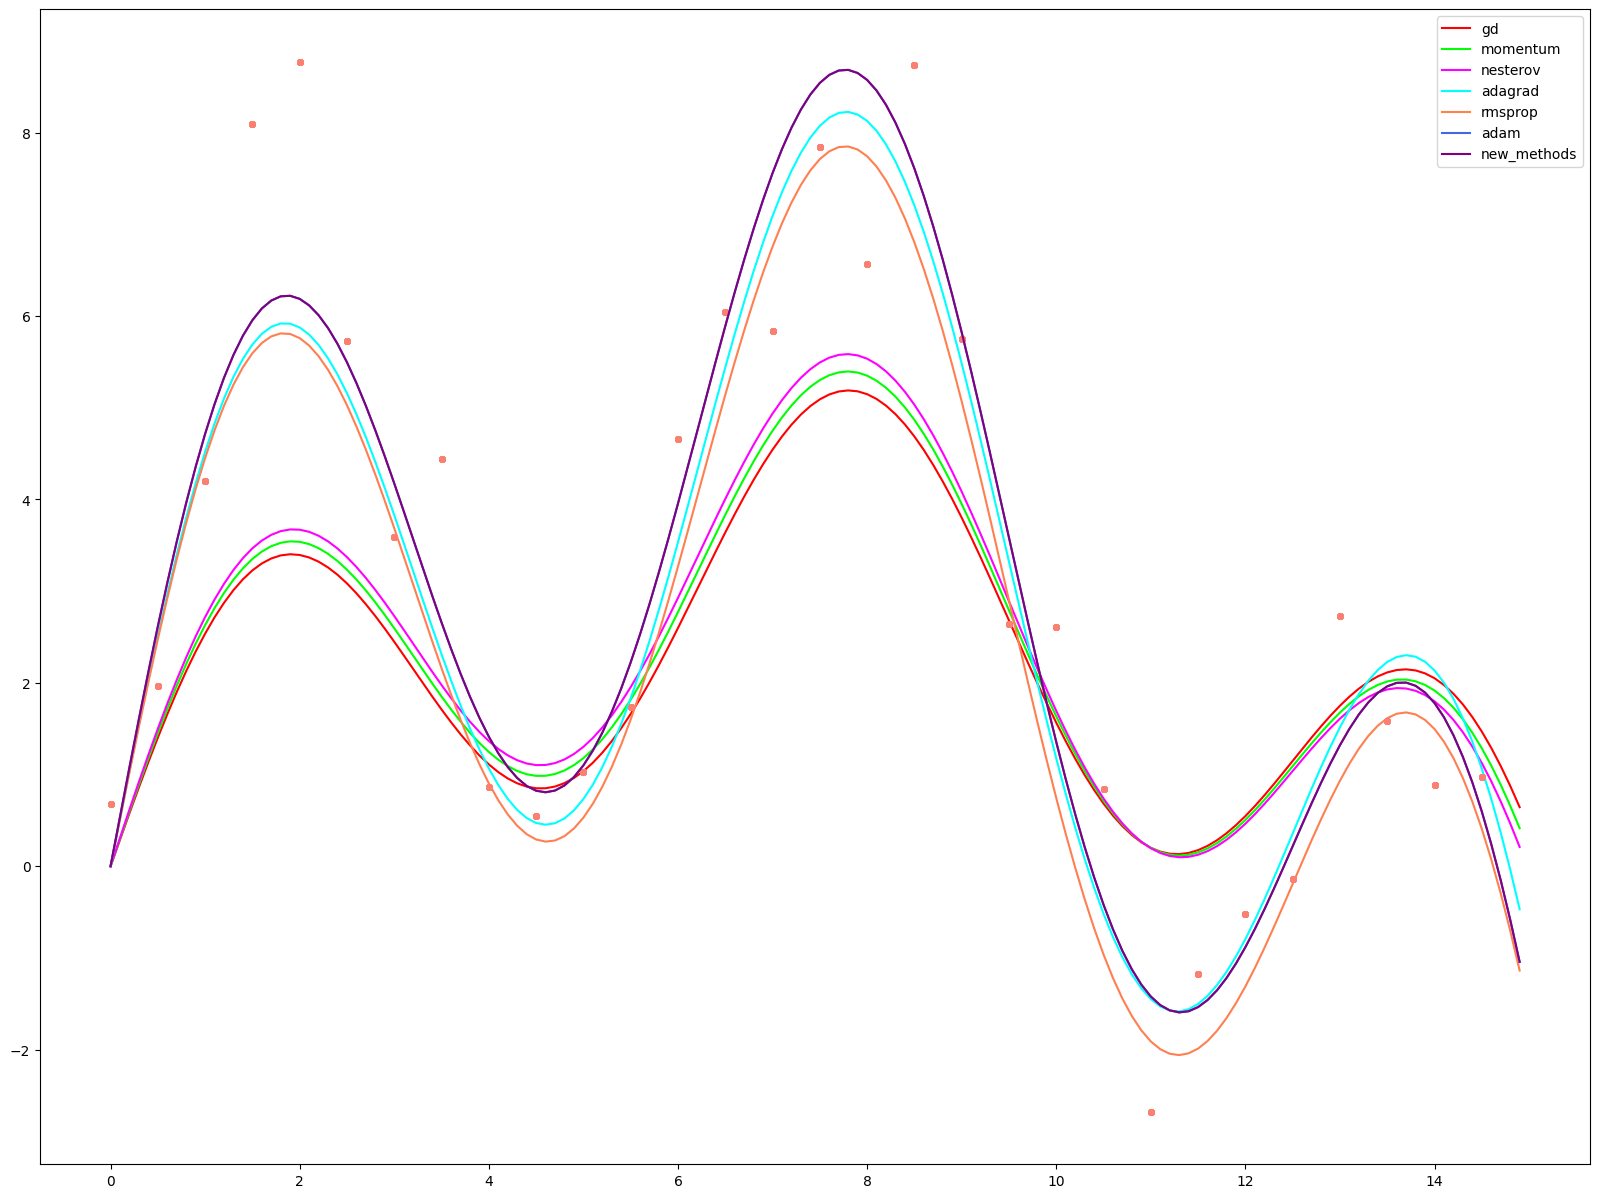

initial: [-2, -2, -2, -2]
current_cost: 1380.70948951460, epoch: 499     gd
current_cost: 351.816828974624, epoch: 499     momentum
current_cost: 1617.25393471661, epoch: 499     nesterov
current_cost: 37.7747781301845, epoch: 499     adagrad
current_cost: 56.9183018387588, epoch: 499     rmsprop
current_cost: 34.9293834740895, epoch: 376     adam
current_cost: 34.9293734533875, epoch: 2     newton
current_cost: 34.9293734533875, epoch: 5     dogleg
current_cost: 34.9293734533921, epoch: 16     bfgs
current_cost: 34.9293734542258, epoch: 34     l-bfgs


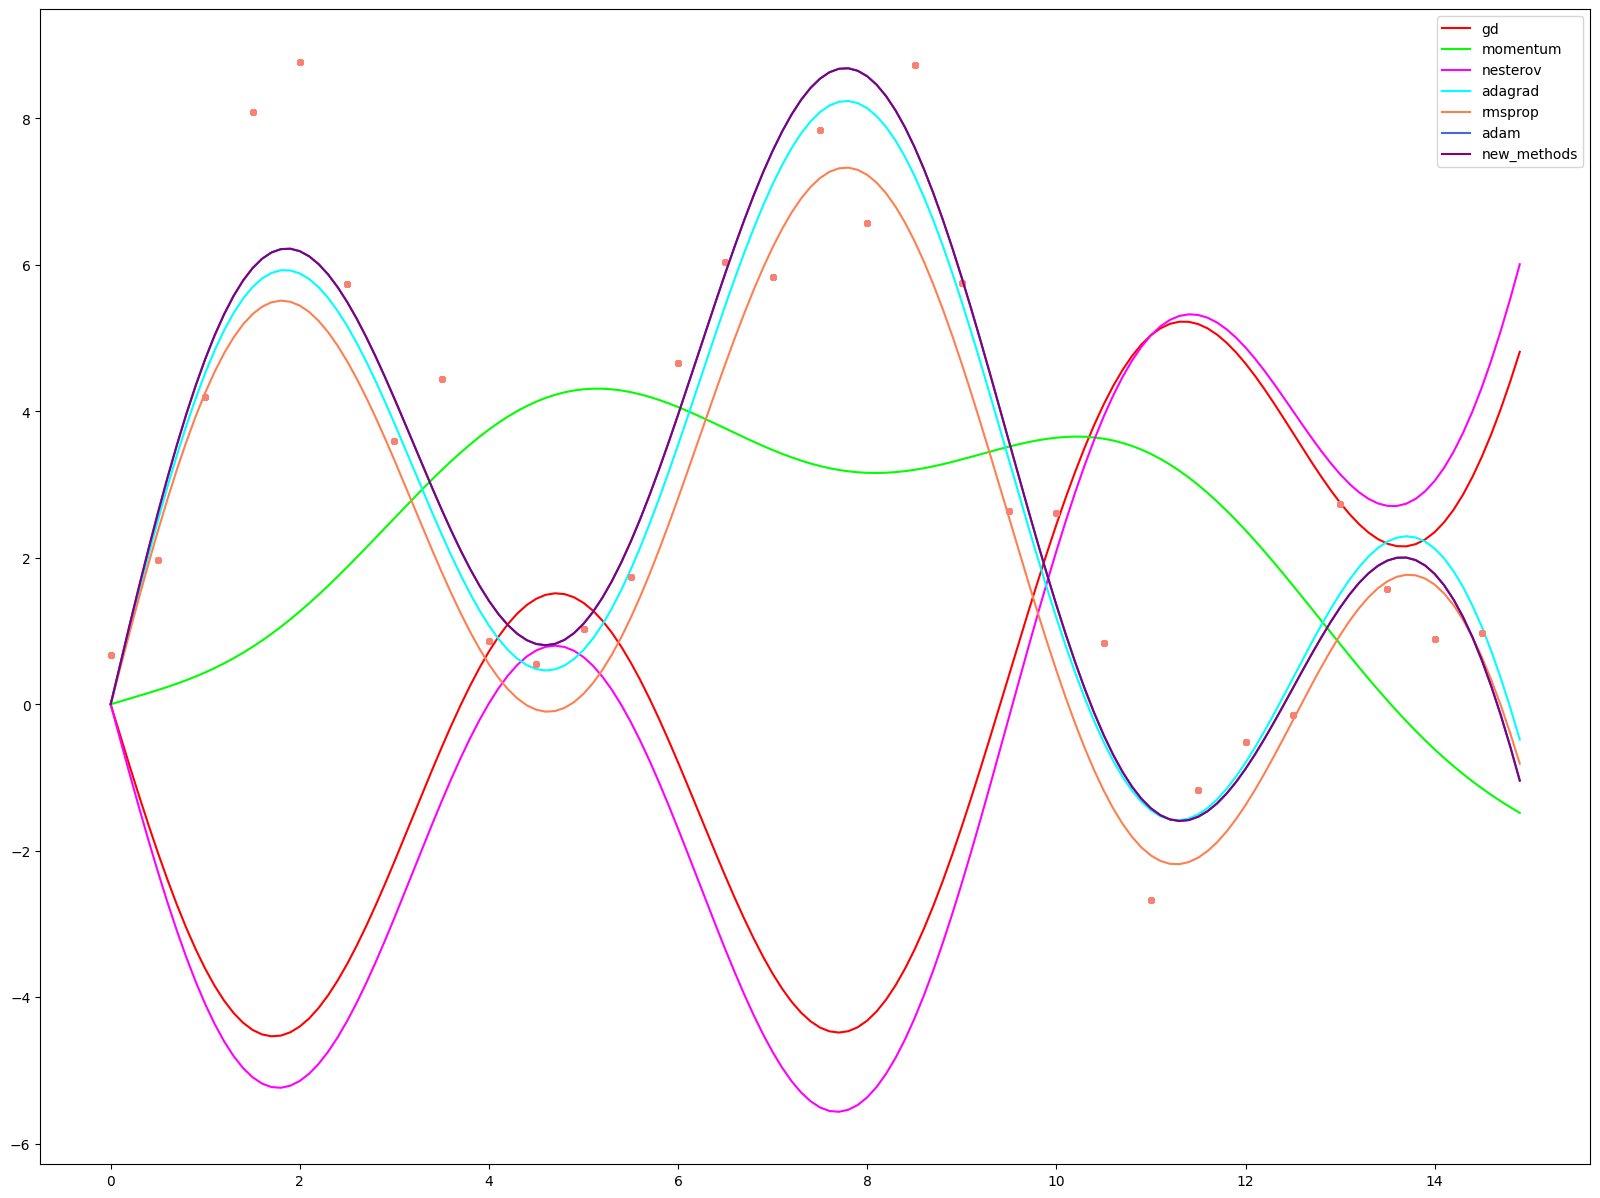

In [266]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1] * 4
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sin(x)

X_new = np.arange(0, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 4 * sp.sin(x) + x ** 0.5 - 0.1 * x ** 2 + 1 * x

func1 = symbols[0] * sp.sin(x) + symbols[1] * sp.sqrt(x) + symbols[2] * x ** 2 + symbols[3] * x 


func = sp.lambdify([symbols, x], func1, {"sin":mysin, "sqrt":mysqrt})

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-7, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.007, eps=eps)
result[5] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[6] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[7] = powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
result[8] = bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[9] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'new_methods']

plt.rcParams["figure.figsize"] = (20, 15)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

# мне впадлу это как то обобщать, честно (там разные lr если че)

INITIAL_THETA = [-2] * 4

print("initial:", INITIAL_THETA)

result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=3e-6, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-5, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.009, eps=eps)
result[5] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[6] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[7] = powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
result[8] = bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[9] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'new_methods']

plt.rcParams["figure.figsize"] = (20, 15)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

### 2 функция

initial: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
current_cost: 15886.34741825432, epoch: 499     gd
current_cost: 15901.585770508633, epoch: 499     momentum
current_cost: 15153.12485332288, epoch: 499     nesterov
current_cost: 1152.0287277607858, epoch: 499     adagrad
current_cost: 6291.113580272944, epoch: 499     rmsprop
current_cost: 1052.3979079666674, epoch: 499     adam
current_cost: 42.40109672661976, epoch: 2     newton
current_cost: 42.40109672661913, epoch: 7     dogleg
current_cost: 42.401096726900604, epoch: 37     bfgs
current_cost: 56.382889639202325, epoch: 163     l-bfgs
current_cost: 43.19627681847428, epoch: 137     l-bfgs


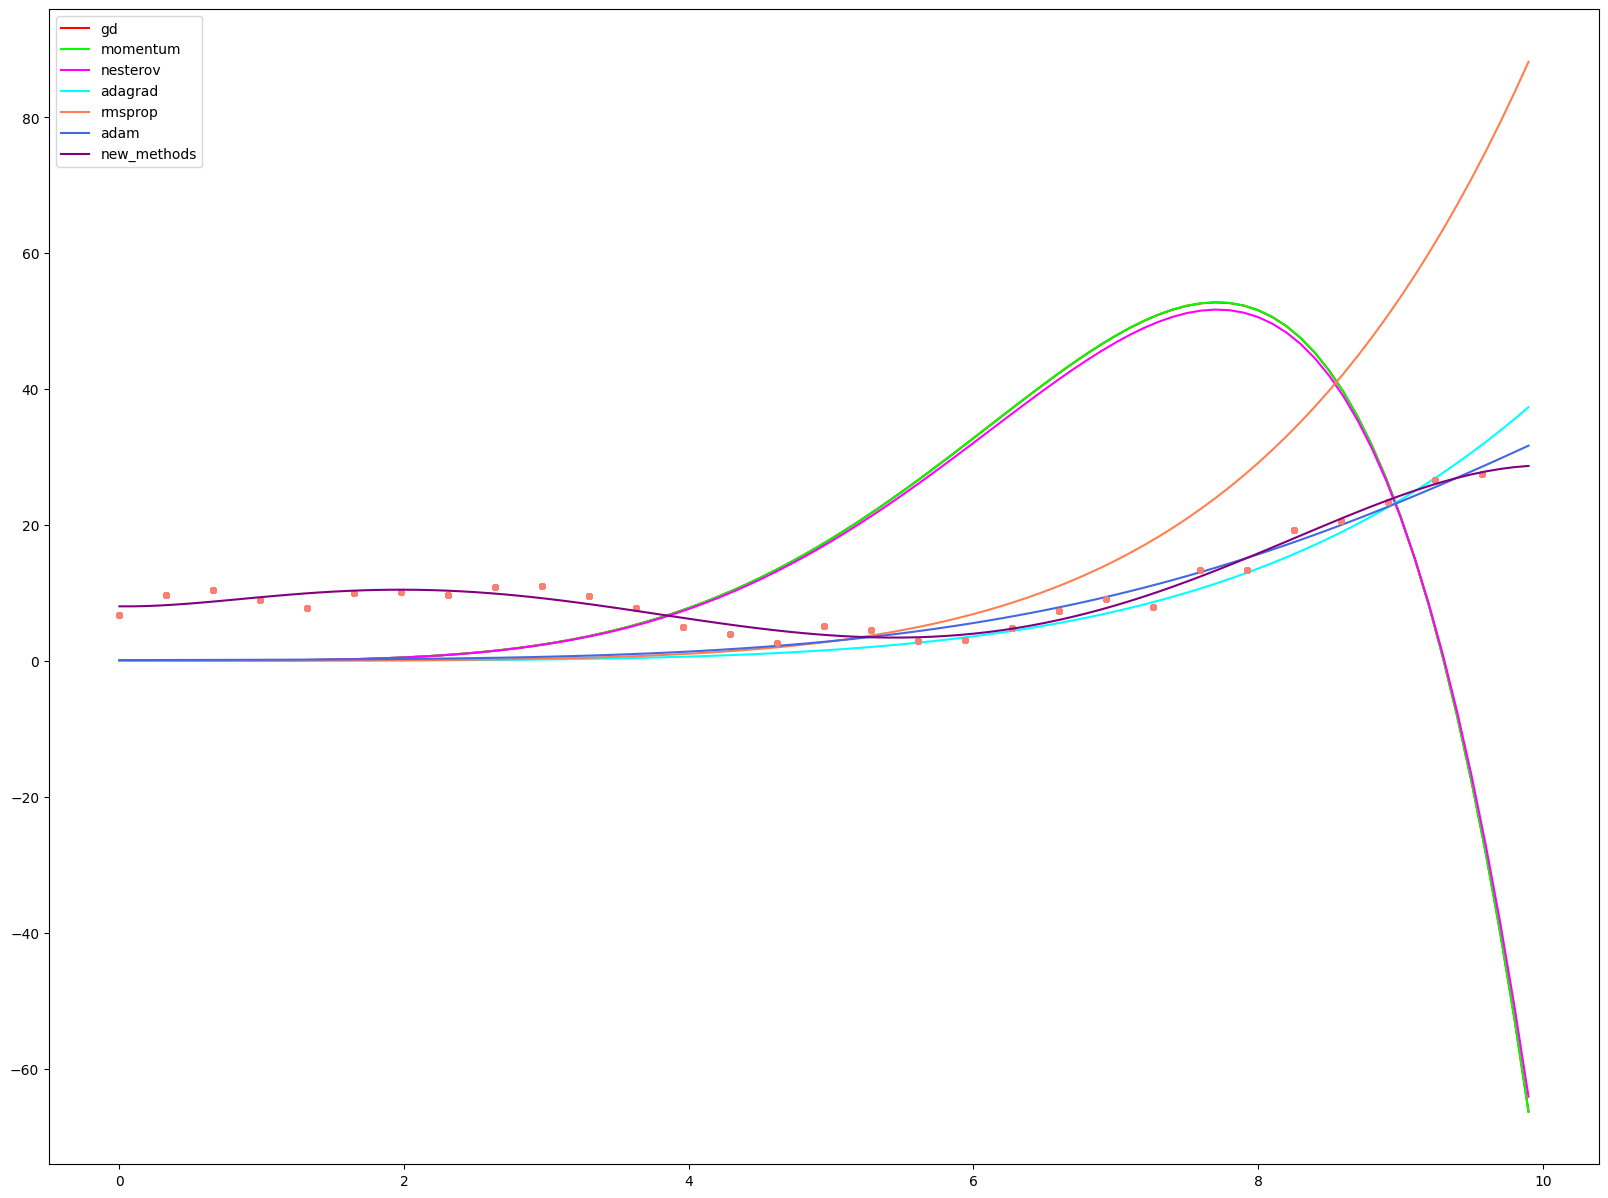

initial: [-0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002]
current_cost: 2745.3106504177504, epoch: 499     gd
current_cost: 2746.972242998941, epoch: 499     momentum
current_cost: 2665.345603463575, epoch: 499     nesterov
current_cost: 1152.034676362288, epoch: 499     adagrad
current_cost: 6277.484972653219, epoch: 499     rmsprop
current_cost: 1052.765373415043, epoch: 499     adam
current_cost: 42.40109672662003, epoch: 2     newton
current_cost: 42.4010967266187, epoch: 7     dogleg
current_cost: 42.40109672662089, epoch: 37     bfgs
current_cost: 56.39054495938084, epoch: 175     l-bfgs
current_cost: 56.39055341725281, epoch: 110     l-bfgs


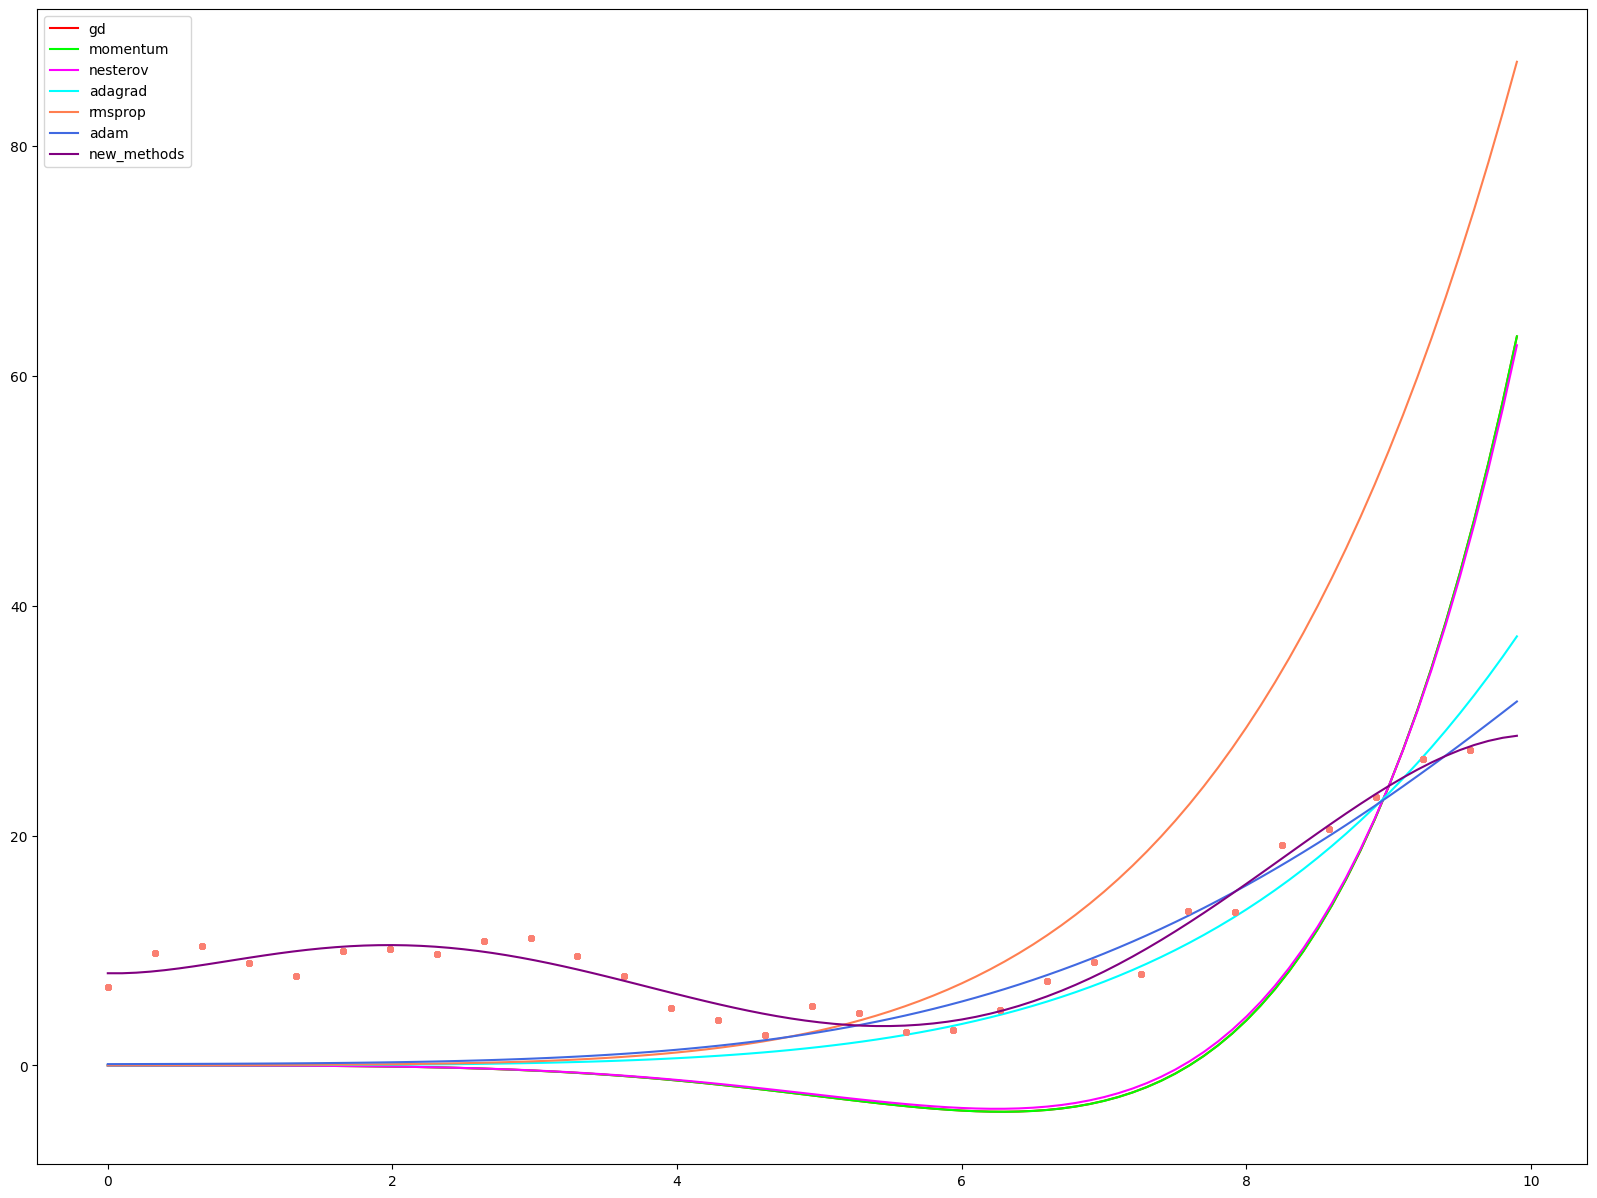

In [222]:
TOTAL = 30
STEP = 0.33
FROM = 0
INITIAL_THETA = [0.01] * 7
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sin(x)

X_new = np.arange(0, 10, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 8 + x + 1 * x ** 2 -0.7 * x ** 3 + 0.1 * x ** 4 - 0.002 * x ** 5 - 0.00019 * x ** 6

func1 = symbols[0] + symbols[1] * x + symbols[2] * x ** 2 + symbols[3] * x ** 3 + symbols[4] * x ** 4 + symbols[5] * x ** 5 + symbols[6] * x ** 6


func = sp.lambdify([symbols, x], func1, 'numpy')

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) + np.random.uniform(-1, 1) * np.random.uniform(1, 3) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.0001, eps=eps)
result[5] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[6] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[7] = powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
result[8] = bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[9] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8)

# если поменять m, то l-bfgs заебись становится 
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40)

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'new_methods']

plt.rcParams["figure.figsize"] = (20, 15)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

# мне впадлу это как то обобщать, честно (там разные lr если че)

INITIAL_THETA = [-0.002] * 7

print("initial:", INITIAL_THETA)

result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=2e-13, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=100, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=0.0001, eps=eps)
result[5] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1, eps=eps)

result[6] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[7] = powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
result[8] = bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[9] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8)

# если поменять m, то l-bfgs заебись становится 
lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8, m=40)

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'new_methods']

plt.rcParams["figure.figsize"] = (20, 15)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()

### 3 функция

initial: [1.1, -0.1, 0.003]
current_cost: 3000.9510674785733, epoch: 499     gd
current_cost: 2959.7289221865267, epoch: 499     momentum
current_cost: 2721.6079722045083, epoch: 499     nesterov
current_cost: 41584.4527902963, epoch: 499     adagrad
current_cost: 13722.206655449856, epoch: 105     rmsprop
current_cost: 1060.0553129405516, epoch: 499     adam
current_cost: 3.1969054478400705e-13, epoch: 6     newton
current_cost: 9.400614371069207e-23, epoch: 8     dogleg


<ipython-input-55-5baa025edd40>:49: RuntimeWarning: divide by zero encountered in double_scalars
  ro = 1.0 / (np.dot(yk, sk))
<ipython-input-55-5baa025edd40>:50: RuntimeWarning: invalid value encountered in multiply
  A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
<ipython-input-55-5baa025edd40>:51: RuntimeWarning: invalid value encountered in multiply
  A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
<ipython-input-55-5baa025edd40>:52: RuntimeWarning: invalid value encountered in multiply
  Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * sk[:, np.newaxis] * sk[np.newaxis, :])


current_cost: 14381.222077296783, epoch: 2     bfgs


<ipython-input-207-823c6ec157c0>:73: RuntimeWarning: divide by zero encountered in double_scalars
  rho = 1.0 / (np.dot(yk, sk))


current_cost: 14381.222077296783, epoch: 2     l-bfgs


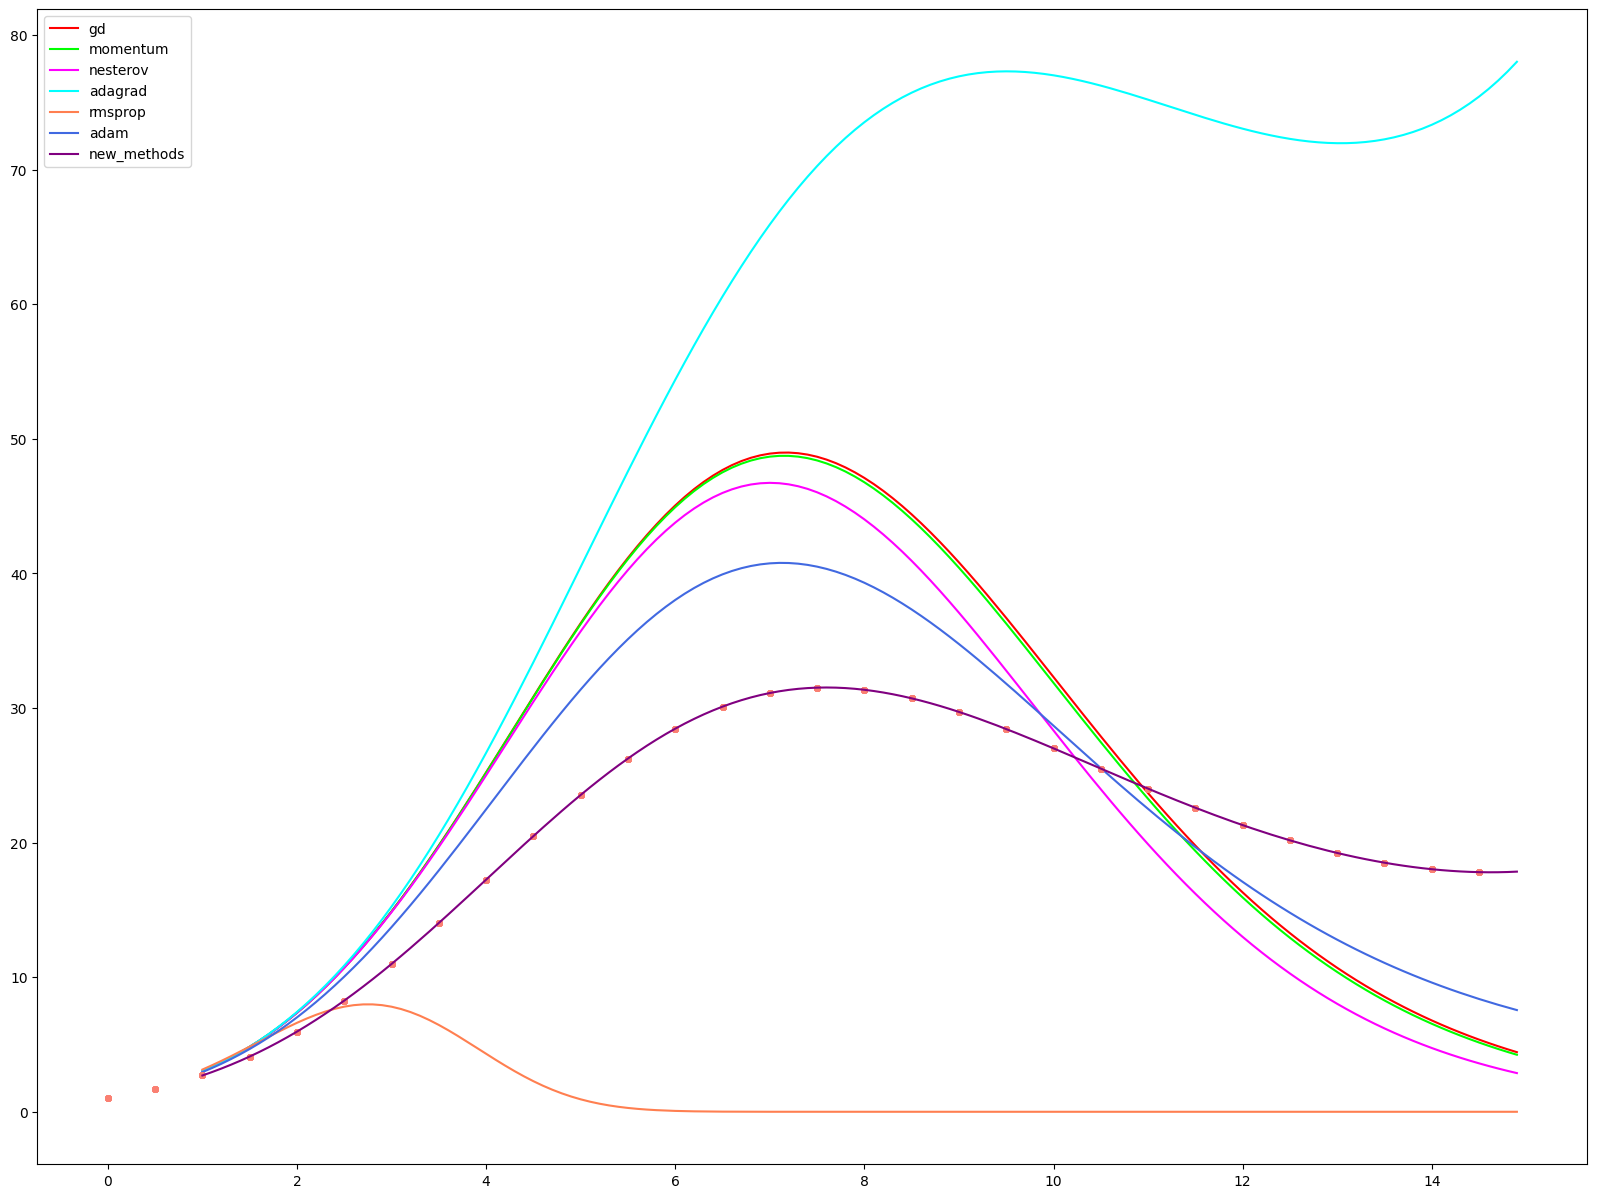

In [265]:
TOTAL = 30
STEP = 0.5
FROM = 0
INITIAL_THETA = [1.1, -0.1, 0.003]
lr = 1
eps = 1e-6

def mysin(x):
    return sp.sin(x)

def mysqrt(x):
    return sp.sin(x)

X_new = np.arange(1, 15, 0.1, dtype=np.float64)


symbols = sp.symbols(f"x:{len(INITIAL_THETA)}")
x = sp.symbols("x")
y = sp.symbols("y")

def function1(x):
  return 3 ** (x - 0.1 * x ** 2 + 0.003 * x ** 3)

func1 = 3 ** (symbols[0] * x + symbols[1] * x ** 2 + symbols[2] * x ** 3)


func = sp.lambdify([symbols, x], func1, 'numpy')

loss_func = (y - func(symbols, x)) ** 2
loss_function_grad = [sp.diff(loss_func, symbol) for symbol in symbols]
loss_function_grad = [sp.lambdify([symbols, y, x], grad, 'numpy') for grad in loss_function_grad]

hessian = [[sp.diff(sp.diff(loss_func, a), b) for a in symbols] for b in symbols]
hessian_func = [[i for i in range(len(hessian))] for _ in range(len(hessian[0]))]
for i in range(len(hessian)):
  for j in range(len(hessian[i])):
    hessian_func[i][j] = sp.lambdify([symbols, y, x], hessian[i][j], 'numpy')

X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
Y = np.array([function1(x1) for x1 in X], dtype=np.float64)

print("initial:", INITIAL_THETA)
result = [0 for i in range(10)]

result[0] = gd(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-13, eps=eps)
result[1] = gd_with_momentum(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-13, eps=eps)
result[2] = gd_with_nesterov(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-13, eps=eps)
result[3] = gd_with_adagrad(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-6, eps=eps)
result[4] = gd_with_rmsprop(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-2, eps=eps)
result[5] = gd_with_adam(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, lr=1e-4, eps=eps)

result[6] = gauss_newton(X, Y, INITIAL_THETA, loss_function, func, eps=eps)
result[7] = powell_dog_leg(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, hessian_func, eps=eps)
result[8] = bfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=eps)
result[9] = lbfgs(X, Y, INITIAL_THETA, loss_function, func, loss_function_grad, symbols, eps=1e-8)

# бля я хз оставлять ли это, выглядит пиздато, но ошибки в l-bfgs мне не нравятся))))))))))) 
# да поебать мне кажется, в отчет че нибудь придумаем по цифорам

colors = ['red', 'lime', 'fuchsia', 'aqua', 'coral', 'royalblue', 'purple']
labels = ['gd', 'momentum', 'nesterov', 'adagrad', 'rmsprop', 'adam', 'new_methods']

plt.rcParams["figure.figsize"] = (20, 15)
fig, ax = plt.subplots()

for i in range(len(labels)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [func(result[i], p) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
ax.legend()
plt.show()